In [1]:
import os
import joblib
import pickle
import numpy as np
import tensorflow as tf
import support_functions as sf
import matplotlib.pyplot as plt
import keras.layers as layers
import sklearn.model_selection as model_selection

from glob import glob
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from keras import Sequential, Model
from keras.callbacks import Callback

# GPU
sf.limit_gpu_memory(8192)
sf.gpu_check()

True

## Business understanding

Ischemische hartziekten zorgen ervoor dat er onvoldoende zuurstofrijk bloed door het lichaam wordt getransporteerd en ontstaan door de verkalking van de aderen. In Nederland overlijden hier gemiddeld per dag 14 mannen en 8 vrouwen aan. Het Isala Zwolle is een regioziekenhuis dat zich ook specialiseert in deze groep aandoeningen. 

In samenwerking met het lectoraat ICT Innovaties in de Zorg, is gekeken of de mogelijkheid bestaat tot het optimaliseren van het diagnosticeringsproces binnen deze groep aandoeningen met de inzet van machine learning technieken. Dit kan worden bereikt door Convolutionaire Neurale Netwerken in te zetten om classificatie uit te voeren van hart-scans waarin zich kalk bevindt. Dit kan uiteindelijk leiden tot een efficiënter bedrijfsproces waarbij artsen *meer tijd overhouden voor andere taken* en *kosten worden bespaard*.

Uit een vorig onderzoek is gebleken dat momenteel nog niet een voldoende presterend classificatiemodel kan worden ontwikkeld om kalk in het hart vast te stellen. Enerzijds door een tekort aan gelabelde data en anderzijds een tekort aan verklarende variabelen; medische scans hebben geen kleurenkanalen wat de classificatie bemoeilijkt.

Door een bepaalde type afbeelding te corrumperen en deze daarna door een CNN te laten herstellen, ontstaat een encoder met welke de *latent space* in een bepaald afbeeldingstype vorm krijgt. Deze latent space kan worden gezien als een reeks ingebedde eigenschappen die karakteristiek zijn voor - in dit geval -  medische scans.

De encoder  uit dit model kan voorts worden gebruikt om een classificatiemodel te pretrainen zodat er minder gelabelde data nodig is voor dit proces en de aanwezige features worden uitgebreid (analysis) gedeelde uit onderstaande afbeelding). Deze nieuwe features zijn uniek voor het type 'medische scans'. Het idee van deze encoder is door het lectoraat aangereikt in de vorm van het paper *Self-supervised learning for medical image analysis using image context restoration*.

Hieronder is een afbeelding te zien van de manier waarop de image gecorrumpeerd kan worden; het uitsnijden van random vlakken rondom een centrum. Bij c is te zien welk van de vlakken gaat worden voorspeld. 
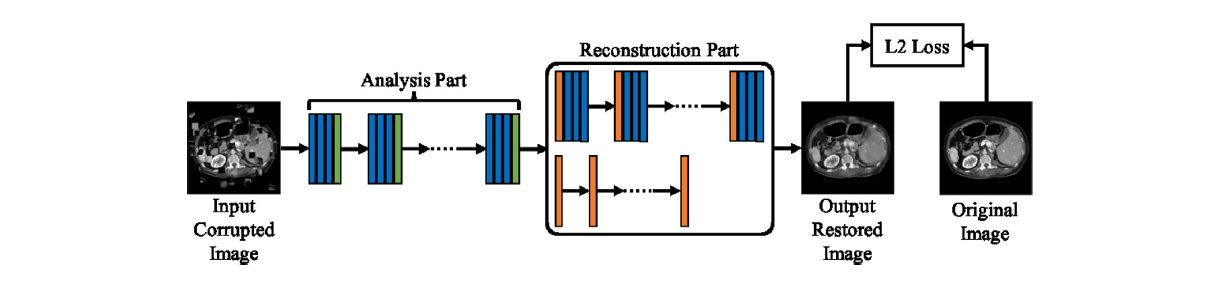
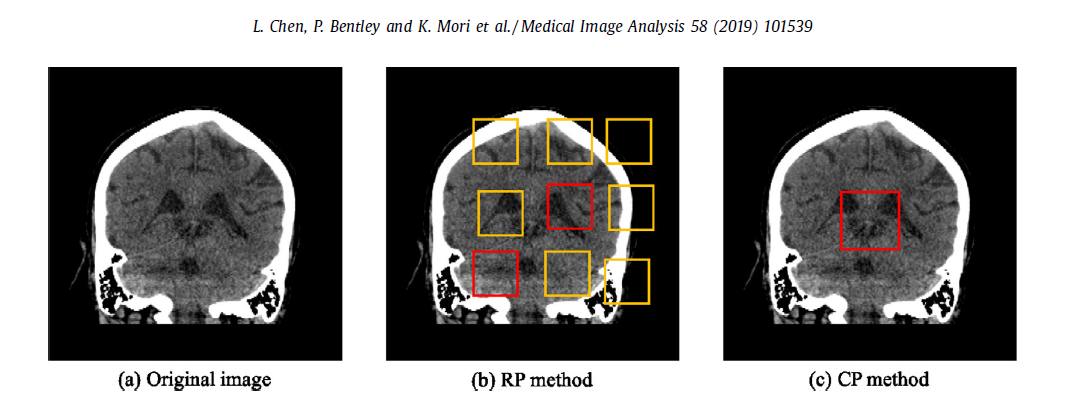


## Data understanding

De dataset bestaat uit een verzameling DICOM-bestanden. Dit is een standaard voor medische bestanden.

Hieronder worden een aantal scans als voorbeeld getoond. Voor het vervolg wordt er gebruik gemaakt van een kleine subselectie van de oorspronkelijke dataset aangezien het hier gaat om het conceptueel nabouwen van het model uit de paper waarna deze verder zal worden uitgewerkt.

Inladen en tonen slices scans.

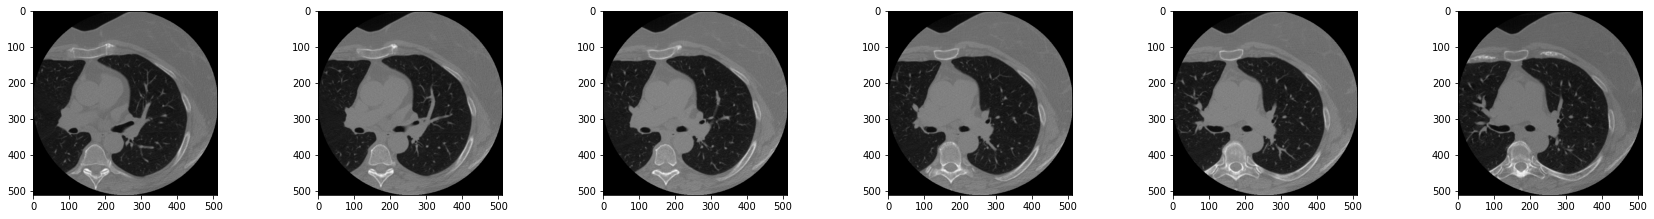

In [2]:
normal_slices = sf.read_dicom_slices('scans/small_example_scan')
sf.display_dicom_slices(normal_slices)

Shape

In [3]:
normal_slices.shape

(6, 512, 512)

Hieronder is te zien uit welke range van waarden elk van de CT-slices bestaan. Het gaat hier om ca -60 en 2300.

In [5]:
# wat is de range van waarden?
def min_max_values(normal_slice):
    return np.min(normal_slice), np.max(normal_slice)

[min_max_values(i) for i in normal_slices]

[(-64, 2291), (-63, 2210), (-62, 2142), (-62, 2187), (-62, 2161), (-65, 2358)]

Checken op NaNs.

In [24]:
[np.isnan(j).sum() for j in normal_slices]

[0, 0, 0, 0, 0, 0]

Er is reeds een verzameling gemaakt van de max-waarde van elke scan. deze zijn heironder te zien. Hier zal verder in het notebook mee worden verder gewerkt.

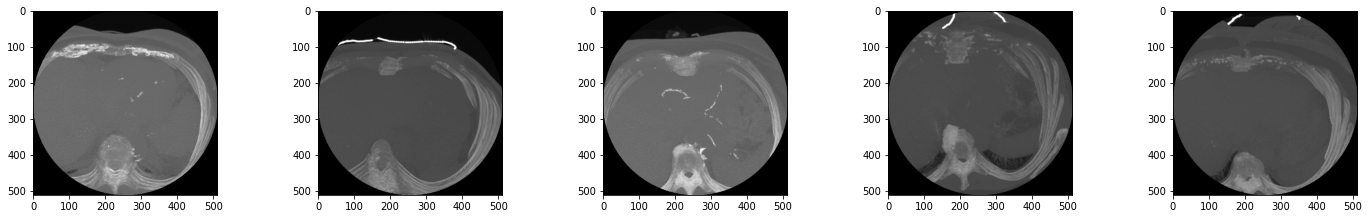

In [3]:
slices = joblib.load('scans/scans_max_normalised_float32.joblib')
sf.display_dicom_slices(slices[0:5])

In [14]:
slices.shape

(502, 512, 512)

In [13]:
[j for j in slices if np.isnan(j).sum() != 0]

[]

## Data preparation

Hieronder worden de slices van scans gecorrumpeerd door patches uit te snijden en deze vervolgens een x aantal keer om te wisselen zodat er verstoring optreedt. Hier is gekozen voor een patch-size van 64 aangezien dit de grootte was dat in het paper stond vermeld. Het aantal switches is bepaald op een laag aantal: in dit geval 3. Het paper gaf hier niks over aan waardoor de aanname is gedaan dat het laagdrempeliger zou zijn voor het model om features te onttrekken uit een scan door te beginnen met een laag aantal switches. Een laag aantal switches zorgt namelijk voor een beperkte verstoring van de oorspronkelijke scans. Deze switches kunnen uiteindelijk opgehoogd worden wanneer dit geen goede resultaten geeft. 

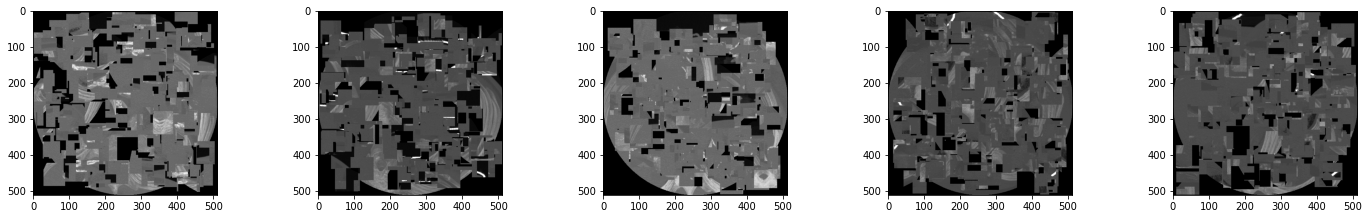

In [29]:
# Corrupt scans
num_swiches = 50
patch_size = 64

corrupted_slices = np.array([sf.corrupt_image(slice, num_swiches, patch_size) for slice in slices])
sf.display_dicom_slices(corrupted_slices[0:5])

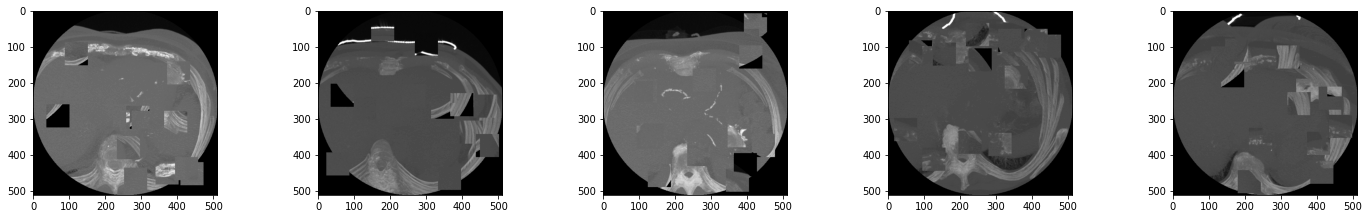

In [27]:
# Corrupt scans
num_swiches = 6
patch_size = 64

corrupted_slices = np.array([sf.corrupt_image(slice, num_swiches, patch_size) for slice in slices])
sf.display_dicom_slices(corrupted_slices[0:5])

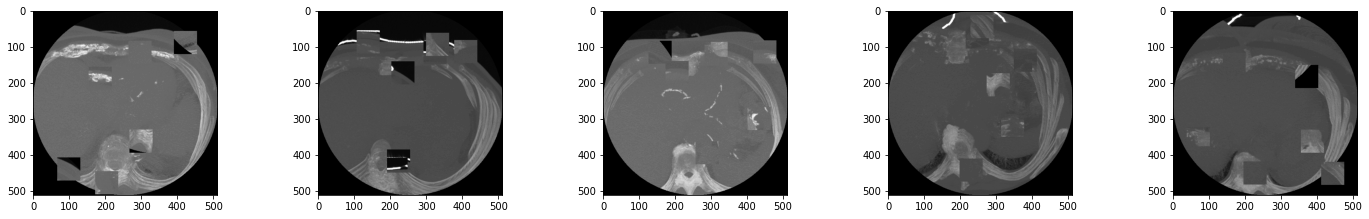

In [26]:
# Corrupt scans
num_swiches = 3
patch_size = 64

corrupted_slices = np.array([sf.corrupt_image(slice, num_swiches, patch_size) for slice in slices])
sf.display_dicom_slices(corrupted_slices[0:5])

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(corrupted_slices, slices, test_size=0.2)

X_train = np.resize(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
y_train = np.resize(y_train, (y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

X_test = np.resize(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
y_test = np.resize(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

In [ ]:
X_train

## Modeling

In [9]:
# Use mulitple GPU's
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [10]:
with strategy.scope():
    analyzer = Sequential(
        [
            layers.Conv2D(128, kernel_size=3, input_shape=(512,512,1), padding='same', activation='relu'),
            layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
            layers.MaxPooling2D(),

            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
        ],
        name="analyzer",
    )
    analyzer.summary()

Model: "analyzer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 128)     1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 256)     295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 256)     590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 256)     590

In [11]:
with strategy.scope():
    reconstructor = Sequential(
        [
            layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding='same', input_shape=(64, 64, 256), activation='relu'),
            layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(1, kernel_size=3, padding='same', activation='relu'),
        ],
        name="reconstructor",
    )
    reconstructor.summary()

Model: "reconstructor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 128, 128, 512)     1180160   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 256)     1179904   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 512, 512, 128)     295040    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 512, 512, 1)       1153      
Total params: 2,656,257
Trainable params: 2,656,257
Non-trainable params: 0
_________________________________________________________________


In [12]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    out_analyzer = analyzer.output
    out_final = reconstructor(out_analyzer)
    model = Model(analyzer.input, out_final)
    
    model.compile(optimizer=opt, loss='mse')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [13]:
MODEL_NAME = '100eps_model_LR_0.001_jan1'
CALLBACK_INTERVAL = 5

model_folder = os.path.join('models', MODEL_NAME)
os.makedirs(model_folder, exist_ok=True)

image = y_train[0]
image_corrupt = sf.corrupt_image(image, num_swiches, patch_size)
image_corrupt_expanded = np.resize(image_corrupt, (1, image_corrupt.shape[0], image_corrupt.shape[1], 1))

plt.imsave(os.path.join(model_folder, 'image.png'), np.resize(image, (image.shape[0], image.shape[1])), cmap=plt.cm.gray)
plt.imsave(os.path.join(model_folder, 'image_corrupt.png'), np.resize(image_corrupt, (image_corrupt.shape[0], image_corrupt.shape[1])), cmap=plt.cm.gray)

class PredictionCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        image_predict = model.predict(image_corrupt_expanded)[0]
        sf.display_triplets(image, image_corrupt, image_predict)
        
        image_path = os.path.join(model_folder, f'{epoch:06d}.png')
        plt.imsave(image_path, np.resize(image_predict, (image_predict.shape[0], image_predict.shape[1])), cmap=plt.cm.gray)
        
class ModelSaveCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        analyzer.save(os.path.join(model_folder, 'analyzer_jan1.h5'))
        reconstructor.save(os.path.join(model_folder, 'reconstructor_jan1.h5'))
        model.save(os.path.join(model_folder, 'complete_jan1.h5'))
        

custom_callbacks = [
    PredictionCallback(),
    ModelSaveCallback()
]

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
51/51 [==============================] - ETA: 0s - loss: 0.0596INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/tas

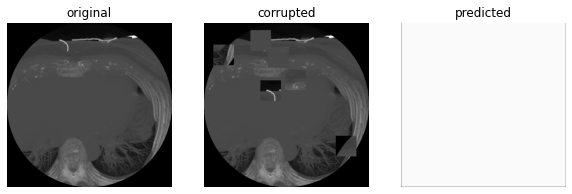

Epoch 2/50
51/51 [==============================] - 17s 329ms/step - loss: 0.0197 - val_loss: 0.0200
Epoch 3/50
51/51 [==============================] - 17s 330ms/step - loss: 0.0160 - val_loss: 0.0047
Epoch 4/50
51/51 [==============================] - 17s 330ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 5/50
51/51 [==============================] - 17s 330ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 6/50
51/51 [==============================] - 17s 330ms/step - loss: 0.0025 - val_loss: 0.0025


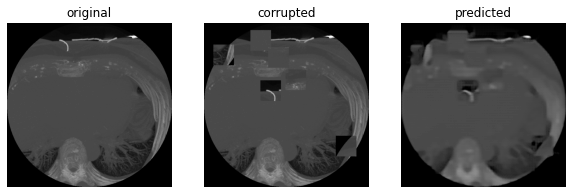

Epoch 7/50
51/51 [==============================] - 17s 331ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 11/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0020 - val_loss: 0.0021


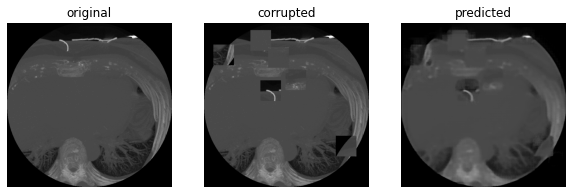

Epoch 12/50
51/51 [==============================] - 17s 331ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 13/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 14/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 15/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 16/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0016 - val_loss: 0.0016


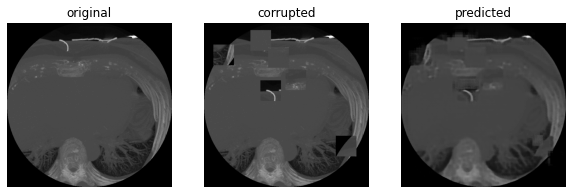

Epoch 17/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 18/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 19/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 20/50
51/51 [==============================] - 17s 331ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 21/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0014 - val_loss: 0.0014


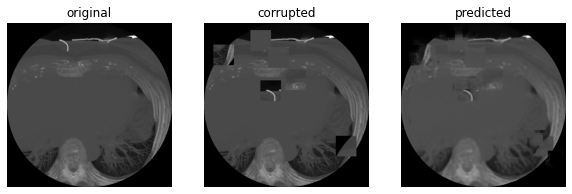

Epoch 22/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 23/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 24/50
51/51 [==============================] - 17s 331ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 25/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 26/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0014 - val_loss: 0.0013


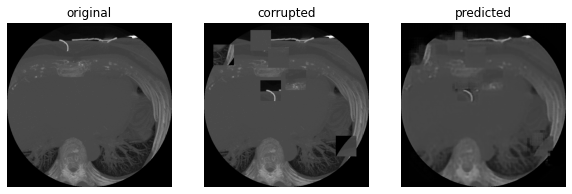

Epoch 27/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 28/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 29/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 30/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 31/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0012 - val_loss: 0.0012


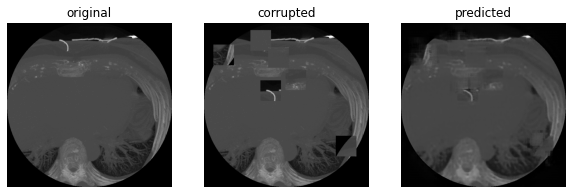

Epoch 32/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 33/50
51/51 [==============================] - 17s 331ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 34/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 35/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 36/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0012 - val_loss: 0.0013


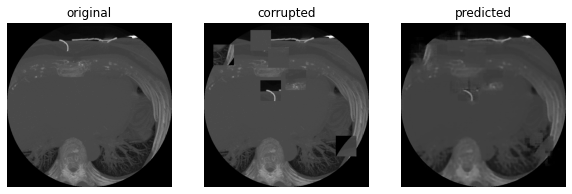

Epoch 37/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 38/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 39/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 40/50
51/51 [==============================] - 17s 331ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 41/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0010 - val_loss: 0.0011


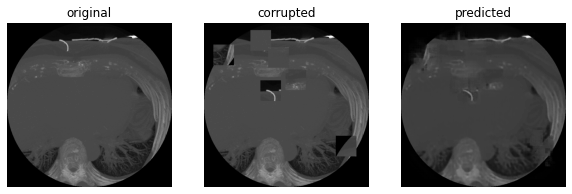

Epoch 42/50
51/51 [==============================] - 17s 332ms/step - loss: 9.8055e-04 - val_loss: 0.0012
Epoch 43/50
51/51 [==============================] - 17s 333ms/step - loss: 9.5689e-04 - val_loss: 0.0011
Epoch 44/50
51/51 [==============================] - 17s 334ms/step - loss: 9.3680e-04 - val_loss: 0.0011
Epoch 45/50
51/51 [==============================] - 17s 333ms/step - loss: 9.3971e-04 - val_loss: 0.0012
Epoch 46/50
51/51 [==============================] - 17s 332ms/step - loss: 9.3520e-04 - val_loss: 0.0010


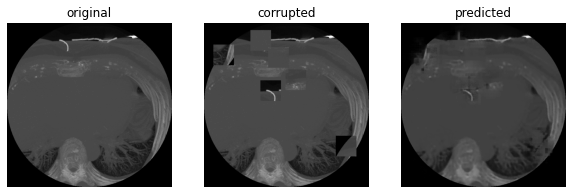

Epoch 47/50
51/51 [==============================] - 17s 333ms/step - loss: 8.8444e-04 - val_loss: 0.0011
Epoch 48/50
51/51 [==============================] - 17s 332ms/step - loss: 8.9060e-04 - val_loss: 0.0012
Epoch 49/50
51/51 [==============================] - 17s 332ms/step - loss: 8.6973e-04 - val_loss: 0.0010
Epoch 50/50
51/51 [==============================] - 17s 332ms/step - loss: 8.5066e-04 - val_loss: 0.0010


In [14]:
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), callbacks=custom_callbacks)

## Evaluation

We zien dat de eerste triplets een predictie hebben van een volledig it vlak. Dit heeft te maken met het feit dat het model nog geen epochs is door gegaan. Verder is te zien dat de validated loss gestaag terugloopt. Deze begint bij 0.02 en daalt na 36 epochs af naar een gemiddelde loss van 0.0011. Deze cijfers zijn ook redelijk repesentatief voor wat er te zien is in de afbeeldingen. 

__Na 6 epochs is te zien dat de patches waziger worden. Dit is met name goed te zien linksboven en rechtsonder.__


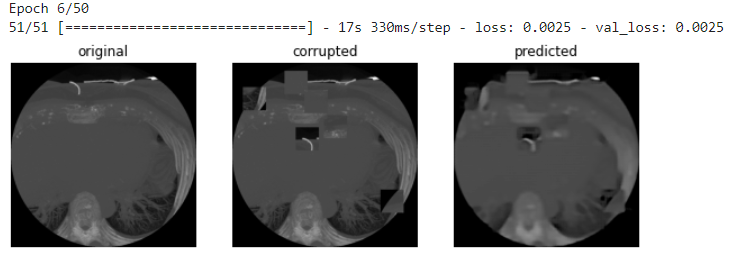

__Na 16 epochs is te zien dat er ook daadwerkelijk lege vlakken worden opgevuld met de kleur van het omliggende gebied.__

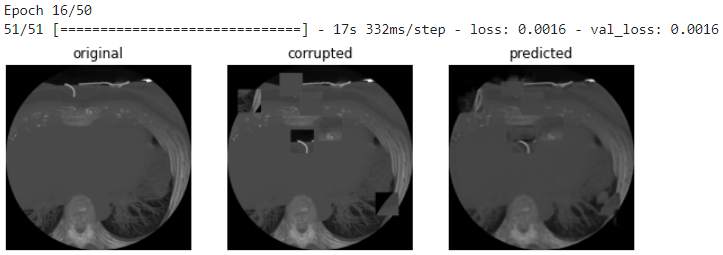

__Na 46 epochs is te zien dat nagenoeg alle lege vlakken binnen in de slice zijn opgevuld terwijl alle omliggende patches die overliepen in het zwarte deel, zijn verdwenen__

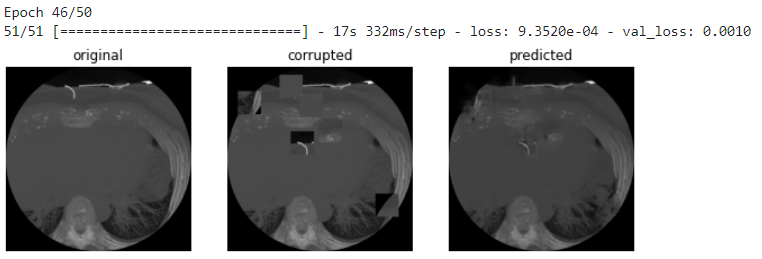

__Op basis van deze bevindingen, kan de conclusie worden getrokken dat met de huidige parameters het model lijkt te doen wat werd verwacht. Het lijkt erop dat de uitgeknipte patches weer worden opgevuld met de omliggende 'context' van de scan. 

## Deployment

Na deze CIRSP-DM cyclus is het model nog niet levensvatbaar om te kunnen worden ingezet bij het classificeren van scans. De eventuele besparingen zijn daarom moenteel nog niet haalbaar. Hierna volgt een nieuwe cyclus waarin enkele parameters worden aangepast. om te kijken of de loss nog lager kan worden dan het minimum van __0.0010__.

# Meer switches

## Data preparation

Hieronder worden de slices van scans gecorrumpeerd door patches uit te snijden en deze vervolgens een x aantal keer om te wisselen zodat er verstoring optreedt. Hier is gekozen voor een patch-size van 64 aangezien dit de grootte was dat in het paper stond vermeld. Het aantal switches is bepaald op een laag aantal: in dit geval 3. Het paper gaf hier niks over aan waardoor de aanname is gedaan dat het laagdrempeliger zou zijn voor het model om features te onttrekken uit een scan door te beginnen met een laag aantal switches. Een laag aantal switches zorgt namelijk voor een beperkte verstoring van de oorspronkelijke scans. Deze switches kunnen uiteindelijk opgehoogd worden wanneer dit geen goede resultaten geeft. 

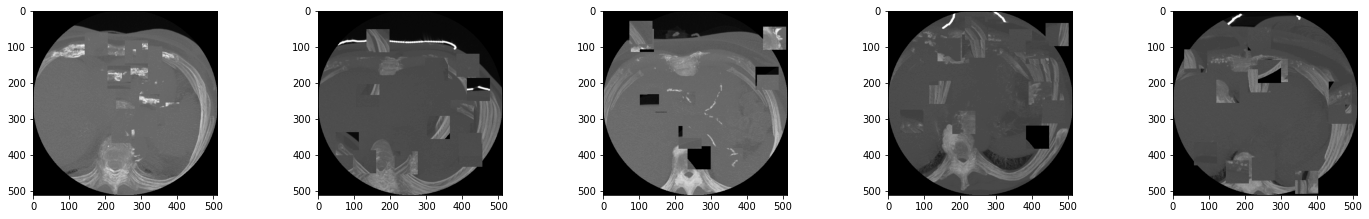

In [15]:
# Corrupt scans
num_swiches = 6
patch_size = 64

corrupted_slices = np.array([sf.corrupt_image(slice, num_swiches, patch_size) for slice in slices])
sf.display_dicom_slices(corrupted_slices[0:5])

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(corrupted_slices, slices, test_size=0.2)

X_train = np.resize(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
y_train = np.resize(y_train, (y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

X_test = np.resize(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
y_test = np.resize(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

## Modeling

In [17]:
# Use mulitple GPU's
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [18]:
with strategy.scope():
    analyzer = Sequential(
        [
            layers.Conv2D(128, kernel_size=3, input_shape=(512,512,1), padding='same', activation='relu'),
            layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
            layers.MaxPooling2D(),

            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
        ],
        name="analyzer",
    )
    analyzer.summary()

Model: "analyzer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 128)     1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 256)     295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 256)     590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 256)     590

In [19]:
with strategy.scope():
    reconstructor = Sequential(
        [
            layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding='same', input_shape=(64, 64, 256), activation='relu'),
            layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(1, kernel_size=3, padding='same', activation='relu'),
        ],
        name="reconstructor",
    )
    reconstructor.summary()

Model: "reconstructor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 128, 128, 512)     1180160   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 256)     1179904   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 512, 512, 128)     295040    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 512, 512, 1)       1153      
Total params: 2,656,257
Trainable params: 2,656,257
Non-trainable params: 0
_________________________________________________________________


In [20]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    out_analyzer = analyzer.output
    out_final = reconstructor(out_analyzer)
    model = Model(analyzer.input, out_final)
    
    model.compile(optimizer=opt, loss='mse')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [21]:
MODEL_NAME = '100eps_model_LR_0.001_jan1'
CALLBACK_INTERVAL = 5

model_folder = os.path.join('models', MODEL_NAME)
os.makedirs(model_folder, exist_ok=True)

image = y_train[0]
image_corrupt = sf.corrupt_image(image, num_swiches, patch_size)
image_corrupt_expanded = np.resize(image_corrupt, (1, image_corrupt.shape[0], image_corrupt.shape[1], 1))

plt.imsave(os.path.join(model_folder, 'image.png'), np.resize(image, (image.shape[0], image.shape[1])), cmap=plt.cm.gray)
plt.imsave(os.path.join(model_folder, 'image_corrupt.png'), np.resize(image_corrupt, (image_corrupt.shape[0], image_corrupt.shape[1])), cmap=plt.cm.gray)

class PredictionCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        image_predict = model.predict(image_corrupt_expanded)[0]
        sf.display_triplets(image, image_corrupt, image_predict)
        
        image_path = os.path.join(model_folder, f'{epoch:06d}.png')
        plt.imsave(image_path, np.resize(image_predict, (image_predict.shape[0], image_predict.shape[1])), cmap=plt.cm.gray)
        
class ModelSaveCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        analyzer.save(os.path.join(model_folder, 'analyzer_jan1.h5'))
        reconstructor.save(os.path.join(model_folder, 'reconstructor_jan1.h5'))
        model.save(os.path.join(model_folder, 'complete_jan1.h5'))
        

custom_callbacks = [
    PredictionCallback(),
    ModelSaveCallback()
]

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
51/51 [==============================] - ETA: 0s - loss: 0.0704INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/tas

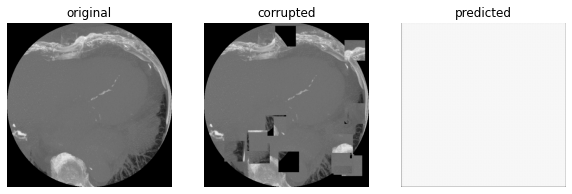

Epoch 2/50
51/51 [==============================] - 17s 331ms/step - loss: 0.0146 - val_loss: 0.0065
Epoch 3/50
51/51 [==============================] - 17s 331ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 4/50
51/51 [==============================] - 17s 331ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 6/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0036 - val_loss: 0.0035


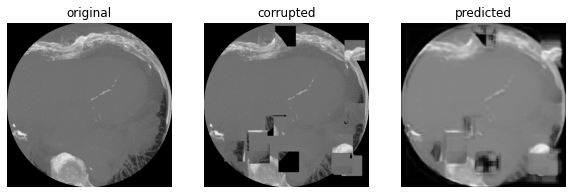

Epoch 7/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 8/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 9/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 10/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 11/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0024 - val_loss: 0.0025


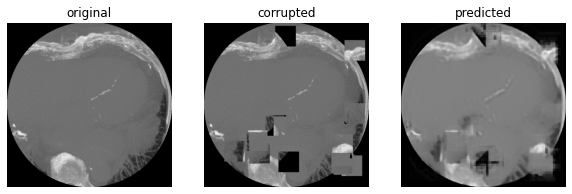

Epoch 12/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 13/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 14/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 15/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 16/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0020 - val_loss: 0.0021


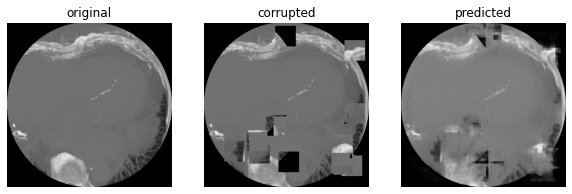

Epoch 17/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 18/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 19/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 20/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 21/50
51/51 [==============================] - 17s 332ms/step - loss: 0.0017 - val_loss: 0.0019


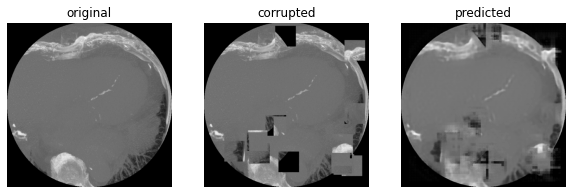

Epoch 22/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 23/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 24/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 25/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 26/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0015 - val_loss: 0.0017


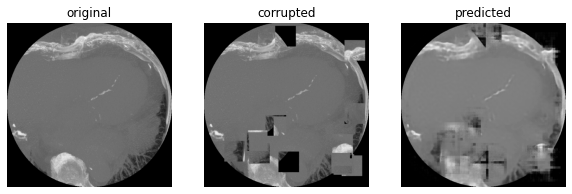

Epoch 27/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 28/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 29/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 30/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 31/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0014 - val_loss: 0.0017


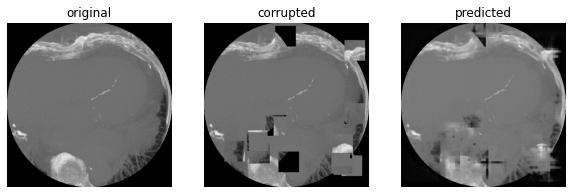

Epoch 32/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 33/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 34/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 35/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 36/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0012 - val_loss: 0.0017


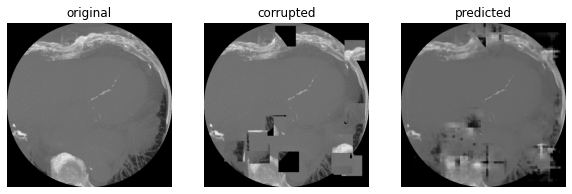

Epoch 37/50
51/51 [==============================] - 17s 333ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 38/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 39/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 40/50
51/51 [==============================] - 17s 335ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 41/50
51/51 [==============================] - 17s 335ms/step - loss: 0.0011 - val_loss: 0.0017


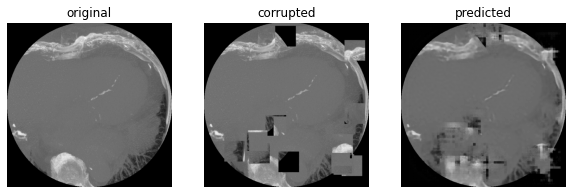

Epoch 42/50
51/51 [==============================] - 17s 335ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 43/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 44/50
51/51 [==============================] - 17s 336ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 45/50
51/51 [==============================] - 17s 334ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 46/50
51/51 [==============================] - 17s 335ms/step - loss: 0.0010 - val_loss: 0.0017


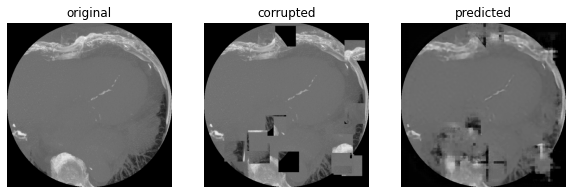

Epoch 47/50
51/51 [==============================] - 17s 335ms/step - loss: 9.9405e-04 - val_loss: 0.0017
Epoch 48/50
51/51 [==============================] - 17s 334ms/step - loss: 9.5752e-04 - val_loss: 0.0016
Epoch 49/50
51/51 [==============================] - 17s 334ms/step - loss: 9.7036e-04 - val_loss: 0.0017
Epoch 50/50
51/51 [==============================] - 17s 335ms/step - loss: 9.5090e-04 - val_loss: 0.0016


In [22]:
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), callbacks=custom_callbacks)

## Evaluation

We zien dat de eerste triplets een predictie hebben van een volledig it vlak. Dit heeft te maken met het feit dat het model nog geen epochs is door gegaan. Verder is te zien dat de validated loss gestaag terugloopt. Deze begint bij 0.02 en daalt na 36 epochs af naar een gemiddelde loss van 0.0011. Deze cijfers zijn ook redelijk repesentatief voor wat er te zien is in de afbeeldingen. 

__Bij de 6e epoch is te zien dat er al wat ruimte wordt opgevuld.__

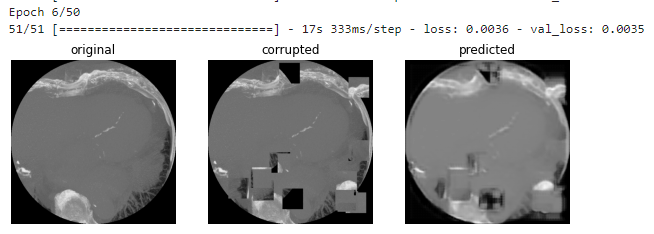

__Na 16 epochs wordt de patch onderin nog beter opgevuld en verdwijnt de omliggende verstoring steeds beter.__

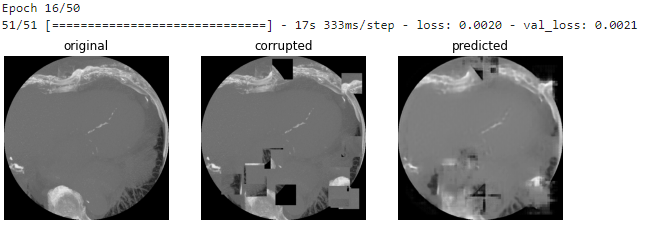

__Vanaf epoch 31 lijkt we weinig te veranderen in de scans. De laatste triplet hieronder laat ook zien dat de patch onderin is opgeuld tot een kruisvorm.__

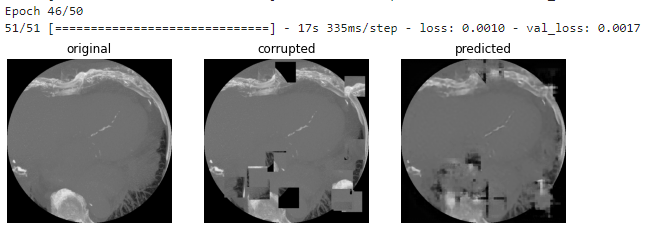